# 期末大作业

In [1]:
import os
import torch
import cv2
import random
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

### 1. 数据处理与数据集搭建

#### 1.1 数据筛选

部分电影没有对应的海报，在数据读取时应筛除这部分电影的数据，最终剩余的电影数目应为N=2938.

In [2]:
all_posters_filename = os.listdir('./poster')
all_posters_index = sorted([int(x[:-4]) for x in all_posters_filename])
all_posters_filename = [f'{i}.jpg' for i in all_posters_index]
df_movie_info = pd.read_csv('./info.csv', index_col=0).loc[all_posters_index, ['name', 'intro']]
df_movie_info

,name,intro
id,,
1,Toy Story (1995),A cowboy doll is profoundly threatened and jea...
2,Jumanji (1995),When two kids find and play a magical board ga...
3,Grumpier Old Men (1995),John and Max resolve to save their beloved bai...
4,Waiting to Exhale (1995),"Based on Terry McMillan's novel, this film fol..."
5,Father of the Bride Part II (1995),George Banks must deal not only with the pregn...
...,...,...
3948,Meet the Parents (2000),Male nurse Greg Focker meets his girlfriend's ...
3949,Requiem for a Dream (2000),The drug-induced utopias of four Coney Island ...
3950,Tigerland (2000),A group of recruits go through Advanced Infant...


#### 1.2 数据预处理

使用合理的方式预处理数据（特别是简介文本）

In [3]:
from stopwords import ENGLISH_STOP_WORDS

import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

def preprocess_intro(intro):
    intro = intro.lower()
    clean_raw = re.sub(r'\s+|`\w*|[^a-z0-9]+', ' ', intro)
    clean_lst = clean_raw.split(' ')
    lemmatizer = WordNetLemmatizer()
    filter_clean = [lemmatizer.lemmatize(word) for word in clean_lst if word not in ENGLISH_STOP_WORDS and len(word) > 1]
    return ' '.join(filter_clean)

def preprocess_intros(intros):
    processed_intros = []
    for intro in intros:
        processed_intros.append(preprocess_intro(intro))
    return processed_intros

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
movie_intros = preprocess_intros(df_movie_info.loc[:, 'intro'].tolist())
movie_names = df_movie_info.loc[:, 'name'].tolist()

Funny Face (1957) 
impromptu fashion shoot book store brings new fashion model discovery shop clerk


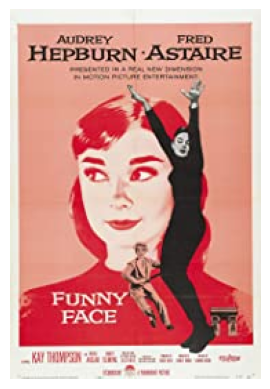

In [6]:
# 检查预处理完成后海报和简介数据的索引是否能够对应
index_for_test = random.randint(0, len(all_posters_index) - 1)

print(movie_names[index_for_test])
print(movie_intros[index_for_test])

file_path=f'./poster/{all_posters_filename[index_for_test]}'
poster = cv2.imread(file_path)

if poster is None:
    print(f"Failed to load poster from: {file_path}")
else:
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    plt.imshow(poster)
    plt.axis('off')
    plt.show()

#### 1.3 数据集搭建

使用60%的数据作为训练集，但与通常的分类任务不同的是，我们使用全100%的数据作为测试集<br>
为尽量避免训练集划分的随机性带来的性能差异，作业环境中提供了train.txt文件，内含作为训练数据的电影id，请不要自行划分训练集

In [7]:
with open('./train.txt', 'r') as f:
    lines = f.readlines()
    train_idx = [int(line.strip()) for line in lines]

posters_train = [all_posters_filename[i] for i in train_idx]
posters_test = all_posters_filename.copy()
intros_train = [movie_intros[i] for i in train_idx]
intros_test = movie_intros.copy()

print(len(posters_train), len(posters_test), len(intros_train), len(intros_test))

1762 2938 1762 2938


In [8]:
from collections import Counter
def build_vocab(sentences, min_freq=1):
    counter = Counter()
    for sentence in sentences:
        words=sentence.split(' ')
        counter.update(words)
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab
vocab = build_vocab(intros_train)

### 2. 模型设计与训练

#### 2.1 模型设计

海报特征提取: CNN、Traditional Features + Linear Layer、...<br>
简介特征提取: TFIDF、RNN/LSTM、nn.Embedding、Pretrained Word Vector、Pretrained Language Model、...<br>
注：如需在简介特征提取中使用基于词频统计、TFIDF等方法，只能使用训练集中的简介数据<br>

以下只是一种可能的写法
- 如果之前已经完成了对海报和简介数据的预处理工作，那么就可以不需要这里的`process_poster`和`process_intro`函数
- 如果之前已经将海报数据全部读入，那么就无需再在`Dataset`类中写一次读取图片的操作（对于小数据集可以这样做，但是对于大型的数据集，全部读进来通常是存不下的，因此更推荐在继承的`Dataset`或者`DataLoader`中实现按需读取和预处理）
- ......

In [9]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [10]:
class MovieLensDataset(Dataset):
    def __init__(self, data_root, posters, intros, **kwargs):
        self.data_root = data_root
        self.posters = posters
        self.intros = intros
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),])
    
    def __len__(self):
        return len(self.posters)
    
    def preprocess_poster(self,idx):
        poster_path = os.path.join(self.data_root, self.posters[idx])
        poster = cv2.imread(poster_path)
        poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
        poster = self.transform(poster)
        return poster
    
    def __getitem__(self, index):
        poster = self.preprocess_poster(index)
        intro = self.intros[index]

        return poster, intro


data_root = './poster'
dataset_train = MovieLensDataset(
    data_root=data_root,
    posters=posters_train,
    intros=intros_train,
)
dataset_test = MovieLensDataset(
    data_root=data_root,
    posters=posters_test,
    intros=intros_test,
)

In [11]:
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(dataset_test, batch_size=32, num_workers=4)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
from transformers import DistilBertTokenizer, DistilBertModel

class PosterModel(nn.Module):
    def __init__(self):
        super(PosterModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True).to(device)
        self.resnet.fc = nn.Identity() 
        self.transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def forward(self, image_tensor):
        image_tensor = self.transform(image_tensor)
        self.resnet.eval()
        with torch.no_grad():
            outputs = self.resnet(image_tensor)
        return outputs
    
class TextModel(nn.Module):
    def __init__(self):
        super(TextModel, self).__init__()
        self.token = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
    
    def forward(self, x):
        text_in = self.token(x, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        text_out= self.model(**text_in)
        text_feat= text_out.last_hidden_state[:, 0, :]
        return text_feat


In [14]:
class CombinedModel(nn.Module):
    def __init__(self, img_d, text_d, common_d):
        super(CombinedModel, self).__init__()
        self.poster_model = PosterModel()
        self.text_model = TextModel()
        self.img_mlp = nn.Sequential(
            nn.Linear(img_d, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, common_d)
        )
        self.text_mlp = nn.Sequential(
            nn.Linear(text_d, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, common_d)
        )

    def forward(self, poster, intro):
        with torch.no_grad():
            poster_feature = self.poster_model(poster)
        with torch.no_grad():
            intro_feature = self.text_model(intro)
        img_feature = self.img_mlp(poster_feature)
        text_feature = self.text_mlp(intro_feature)
        return img_feature, text_feature

#### 2.2 训练流程

问题建模设计、损失函数设计、距离函数设计、...<br>
训练tricks: Optimizer、LR Schedule、...

In [15]:
img_dim = 2048
text_dim = 768
common_dim = 256

model_args = {
    'img_d': img_dim,
    'text_d': text_dim,
    'common_d': common_dim
}

combined_model = CombinedModel(**model_args).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 198.6614
Epoch [2/20], Loss: 168.9466
Epoch [3/20], Loss: 154.6633
Epoch [4/20], Loss: 141.7853
Epoch [5/20], Loss: 128.1065
Epoch [6/20], Loss: 109.1286
Epoch [7/20], Loss: 97.1998
Epoch [8/20], Loss: 85.8855
Epoch [9/20], Loss: 71.2927
Epoch [10/20], Loss: 61.8532
Epoch [11/20], Loss: 41.3728
Epoch [12/20], Loss: 32.7574
Epoch [13/20], Loss: 27.8798
Epoch [14/20], Loss: 24.4242
Epoch [15/20], Loss: 21.8758
Epoch [16/20], Loss: 21.6191
Epoch [17/20], Loss: 19.4549
Epoch [18/20], Loss: 25.5758
Epoch [19/20], Loss: 18.1747
Epoch [20/20], Loss: 16.4247


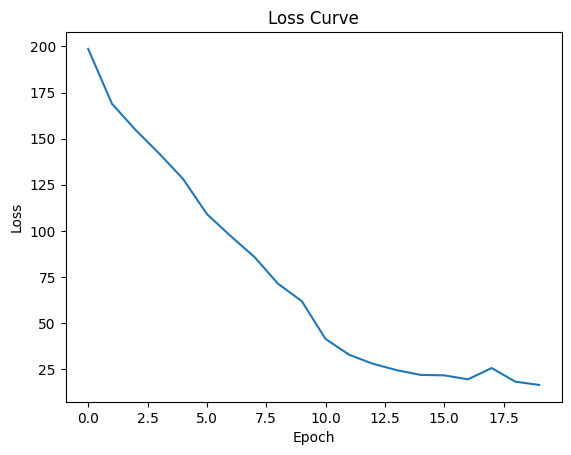

In [16]:
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

def contrastive_loss(img_features, text_features, temperature=0.05):
    cosine_similarity = nn.CosineSimilarity(dim=-1)
    img_features = img_features.unsqueeze(1)
    text_features = text_features.unsqueeze(0)
    similarities = cosine_similarity(img_features, text_features)
    logits = similarities / temperature
    
    labels = torch.arange(len(img_features)).to(logits.device)
    
    loss_img = nn.CrossEntropyLoss()(logits, labels)
    loss_text = nn.CrossEntropyLoss()(logits.T, labels)

    return (loss_img + loss_text) / 2

criterion = contrastive_loss
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

num_epochs = 20
loss_curve = []
for epoch in range(num_epochs):
    combined_model.train()
    total_loss = 0.0
    for poster, intro in train_dataloader:
        poster = poster.to(device)
        optimizer.zero_grad()
        with autocast():
            poster_out,intro_out = combined_model(poster, intro)
            loss = criterion(poster_out,intro_out)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        
    loss_curve.append(total_loss)
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

# save model
torch.save(combined_model.state_dict(), f'model_resnet+distilbert.pth')

# plot loss curve
plt.plot(loss_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

### 3. 测试与分析

#### 3.1 计算Acc
使用训练完的模型在全数据上运行，得到形状为N*N的距离矩阵D，再使用get_acc函数，取ratio=0.05,dim分别为0,1，得到两个acc，作为评测结果

In [17]:
def get_dist_matrix(model, dataloader):
    model.eval()
    img_features = []
    text_features = []
    with torch.no_grad():
        for poster, intro in tqdm(dataloader, total=len(dataloader)):
            poster = poster.to(device)
            img_feature, text_feature = model(poster, intro)
            img_features.extend(img_feature)
            text_features.extend(text_feature)
    
    img_features_tensor = torch.stack(img_features)
    text_features_tensor = torch.stack(text_features)
    
    cosine_similarity = torch.mm(img_features_tensor, text_features_tensor.T)
    img_norm = torch.norm(img_features_tensor, dim=1, keepdim=True)
    text_norm = torch.norm(text_features_tensor, dim=1, keepdim=True)
    
    distances = 1 - cosine_similarity / (img_norm * text_norm.T)
    
    return distances

D_test = get_dist_matrix(combined_model, test_dataloader)


100%|██████████| 92/92 [00:07<00:00, 13.01it/s]


In [18]:
def get_acc(D, ratio=0.05, dim=1):
    '''
    Calculate the accuracy based on the top-k nearest neighbors in the distance matrix.

    Parameters:
    D : torch.Tensor
        The distance matrix with shape (N, N), where 
        D[i, j] represents the distance between poster[i] and intro[j].
    ratio : float
        A float in the range (0, 1) that determines the proportion of nearest neighbors to consider. 
    dim : int
        The dimension along which to compute the top-k neighbors. 
        Use dim=1 for top-k intros for each poster, dim=0 for the top-k posters for each intro.
    '''

    total_samples = len(D)
    k = int(ratio * total_samples)

    _, topk_indices = D.topk(k, dim=dim, largest=False)
    if dim == 0:
        topk_indices = topk_indices.T
    
    correct_matches = 0
    for i in range(total_samples):
        if i in topk_indices[i]:
            correct_matches += 1
    accuracy = correct_matches / total_samples
    return accuracy


In [19]:
accuracy = get_acc(D_test, ratio=0.05, dim=0)
print(f'Accuracy on dim 0: {accuracy * 100:.2f}%')
accuracy = get_acc(D_test, ratio=0.05, dim=1)
print(f'Accuracy on dim 1: {accuracy * 100:.2f}%')

Accuracy on dim 0: 65.66%
Accuracy on dim 1: 66.30%


#### 3.2 分析
选取一些海报/简介，利用你所得到的距离矩阵D挑选出与之距离最接近的top-k（k可自选）简介/海报，尝试对以下问题进行分析<br>
1. （在这一数据集上）电影海报与电影简介内容是否具有某些相关性?<br>
2. 对于给定的海报/简介，最接近的前K个简介/海报是否共享相似的语义内容、主题、风格、或其他特征?<br>
3. 跨模态对齐的特征可能在哪些下游任务上发挥怎么样的作用?<br>
（均为开放性问题，回答合理即可）

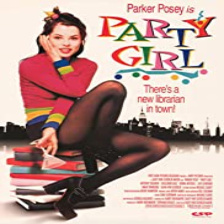

self destructing world vengeful australian policeman set stop violent motorcycle gang
bumbling cadet street inept goon successfully orchestrate metropolitan crime wave
basketball superstar dennis rodman star hip interpol agent attempting defeat deadly plan crazed arm dealer
brother dy mysterious circumstance car accident london gangster jack carter travel newcastle investigate
professional hit man robert rath want fulfill contract retiring unscrupulous ambitious newcomer hit man miguel bain keep killing rath target




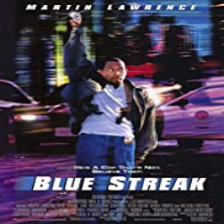

convict pose cop retrieve diamond stole year ago
ex used police lure criminal hiding
australian outback expert protects new york love gangster ve followed
cousin unknowingly rob mob face dangerous consequence
retired master car thief come industry steal car crew night save brother life




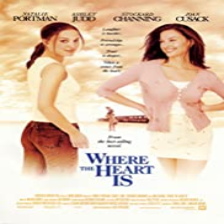

irish catholic brother long island struggle deal love marriage infidelity
real estate hustler wife hide irs amish
ben katie jordan married couple hard time year marriage
self help advocate struggle dysfunctional family place
learning husband infidelity housewife invite itinerant lesbian life




In [20]:
from IPython.display import display
from PIL import Image
import numpy as np
k = 5
cnt=0
while(True):
    cnt+=1
    i = random.randint(0, len(D_test) - 1)
    closest_indices = D_test[i].topk(k, dim=0, largest=False).indices
    poster = (dataset_test[i][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    display(Image.fromarray(poster))

    intros = [dataset_test[i][1] for i in closest_indices]
    for intro in intros:
        print(intro)
    print('\n')
    if cnt>=3:
        break

obese attorney cursed gypsy rapidly uncontrollably lose weight


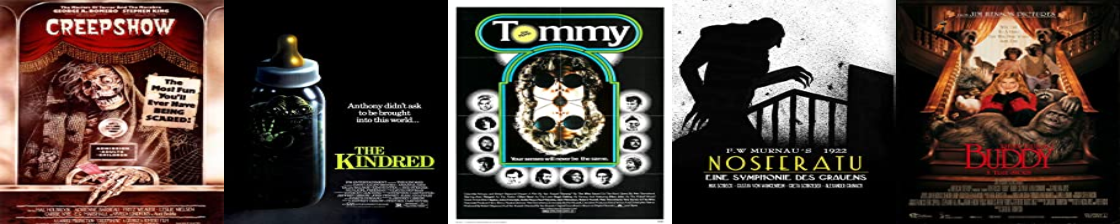

secret service agent frank horrigan clint eastwood couldn save kennedy determined let clever assassin president


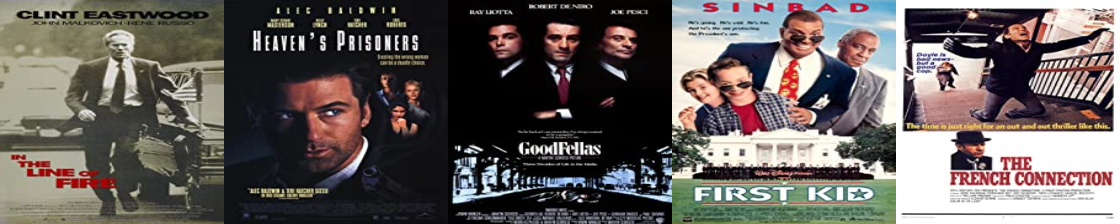

seemingly perfect relationship man wife tested result alcoholism


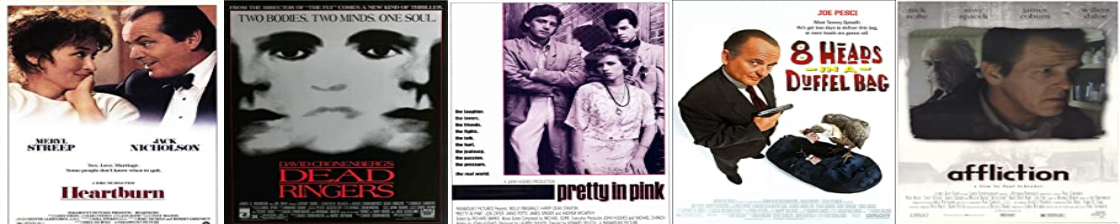

In [21]:
k = 5
cnt=0
while(True):
    cnt+=1
    i = random.randint(0, len(D_test) - 1)
    closest_indices = D_test[:, i].topk(k, dim=0, largest=False).indices
    intro = dataset_test[i][1]
    print(intro)
    posters = [(dataset_test[i][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8) for i in closest_indices]
    display(Image.fromarray(np.concatenate(posters, axis=1)))
    if cnt>=3:
        break

### 4. 延申分析：使用CLIP预训练模型

In [22]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import CLIPProcessor, CLIPModel

class MyModel(nn.Module):
    def __init__(self, pic_d, text_d, common_d):
        super(MyModel, self).__init__()
        self.img_mlp = nn.Sequential(
            nn.Linear(pic_d, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, common_d)
        )
        self.language_mlp = nn.Sequential(
            nn.Linear(text_d, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, common_d)
        )
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
    def encode_text(self,text):
        self.clip_model.eval()
        inputs = self.clip_processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = self.clip_model.get_text_features(**inputs)
        return outputs
    def encode_img(self,poster_tensor):
        self.clip_model.eval()
        inputs = self.clip_processor(images=poster_tensor, return_tensors="pt").to(device)
        outputs = self.clip_model.get_image_features(**inputs)
        return outputs
    
    def forward(self, poster, intro):
        with torch.no_grad():
            intro_feature = self.encode_text(intro)
        with torch.no_grad():
            poster_feature = self.encode_img(poster)
        img_feature = self.img_mlp(poster_feature)
        language_feature = self.language_mlp(intro_feature)
        return img_feature, language_feature

img_dim = 512 
text_dim = 512 
common_dim = 256

model_args = {
    'pic_d': img_dim,
    'text_d': text_dim,
    'common_d': common_dim
}

my_model = MyModel(**model_args).to(device)

criterion = contrastive_loss
optimizer = optim.Adam(my_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scaler = GradScaler()

num_epochs = 20
loss_curve = []
for epoch in range(num_epochs):
    my_model.train()
    total_loss = 0.0
    for poster, intro in train_dataloader:
        poster = poster.to(device)
        optimizer.zero_grad()
        with autocast():
            poster_out,intro_out = my_model(poster, intro)
            loss = criterion(poster_out,intro_out)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        
    loss_curve.append(total_loss)
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

torch.save(my_model.state_dict(), f'model_clip.pth')
D_test = get_dist_matrix(my_model, test_dataloader)
accuracy = get_acc(D_test, ratio=0.05, dim=0)
print(f'Accuracy on dim 0: {accuracy * 100:.2f}%')
accuracy = get_acc(D_test, ratio=0.05, dim=1)
print(f'Accuracy on dim 1: {accuracy * 100:.2f}%')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-06-02 08:16:05.167846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 08:16:05.167902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 08:16:05.169401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

Epoch [1/20], Loss: 207.0637
Epoch [2/20], Loss: 181.1381
Epoch [3/20], Loss: 165.7610
Epoch [4/20], Loss: 145.8534
Epoch [5/20], Loss: 129.7790
Epoch [6/20], Loss: 115.3590
Epoch [7/20], Loss: 97.9000
Epoch [8/20], Loss: 87.4378
Epoch [9/20], Loss: 72.5777
Epoch [10/20], Loss: 71.3620
Epoch [11/20], Loss: 50.6996
Epoch [12/20], Loss: 48.7471
Epoch [13/20], Loss: 40.0256
Epoch [14/20], Loss: 37.6183
Epoch [15/20], Loss: 35.7256
Epoch [16/20], Loss: 32.9691
Epoch [17/20], Loss: 31.2982
Epoch [18/20], Loss: 30.0788
Epoch [19/20], Loss: 28.7112
Epoch [20/20], Loss: 27.8050


100%|██████████| 92/92 [00:22<00:00,  4.13it/s]


Accuracy on dim 0: 62.87%
Accuracy on dim 1: 62.42%
